In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import stumpy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
import os
import sys
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
current = os.path.dirname(os.path.realpath(sys.argv[0]))
parent = os.path.dirname(current)
sys.path.append(parent)

from MotifSig import Motif, NullModel

In [3]:
# Load the audio file
audio_path = '../../../Data/Music Processing/imblue.mp3'
ipd.Audio(audio_path)

In [4]:
#Extract MFCCs
y, sr = librosa.load(audio_path) #22050 sr
n_mfcc = 12
n_fft = int(sr * 0.046)  # 46 milliseconds STFT window
hop_length = int(sr * 0.023)  # 23 milliseconds STFT hop
X = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft, n_mels=32)
X = X.astype(np.float64)
X.shape

(12, 9533)

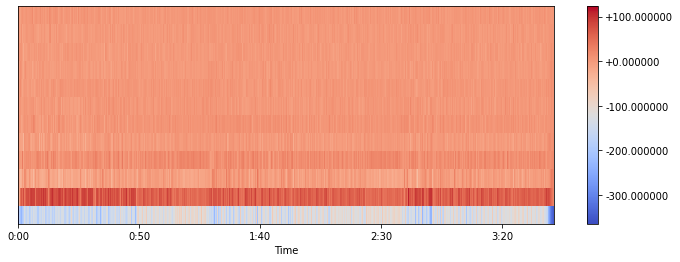

In [5]:
#Visualize MFCCs
plt.figure(figsize=(12,4))
librosa.display.specshow(X, sr=sr, x_axis='time')
plt.colorbar(format="%+2f")
plt.show()

In [6]:
# discover motifs
include = None
normalize = True
subsequence_lengths = [0.5,1,2,3,4,5]

In [7]:
for m in subsequence_lengths:
    m = int(m * sr / hop_length)
    
    mp, mp_indices = stumpy.mstump(X, m, include=include, normalize=normalize)
    #save in results
    np.save('../results/mp/mp_normalized={}_include={}_m={}.npy'.format(normalize,include,m), mp)
    np.save('../results/mp_indices/mp_indices_normalized={}_include={}_m={}.npy'.format(normalize,include,m), mp_indices)

In [8]:
def table_summary_motifs(motif_indices, motif_distances, motif_subspaces, data, m, normalize, max_allowed_dist, excl_zone):
    mp_stats_table = pd.DataFrame(columns=["ID", "k", "Features", "m", "#Matches", "Indices", "max(dists)", "min(dists)", "med(dists)"])

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[:, np.newaxis]
    
    model_empirical = NullModel(data, model="empirical")
    model_gaussian_empirical = NullModel(data, model="kde")
    model_gaussian_theoretical = NullModel(data, model="gaussian_theoretical")

    for motif_indice, match_indices in enumerate(motif_indices):

        dimensions = motif_subspaces[motif_indice]
            
        #remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        #if is empty, skip
        if len(match_indices) == 0:
            continue
        
        #remove trivial matches 
        
        non_trivial_matches = []
        for indice in match_indices:
            trivial = False
            for indice_new in non_trivial_matches:
                if abs(indice - indice_new) < m/2:
                    trivial = True
                    break
            if not trivial:
                non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        #get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][:,match_indices[0]:match_indices[0]+m]
    


        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])
        avg_dist = np.mean(match_distances[1:])
        std_dist = np.std(match_distances[1:])
        med_dist = np.median(match_distances[1:])
        
        #D is distance profile between the motif pattern and Time serie
        if max_allowed_dist is None:
            D = np.empty((n_time-m+1, len(dimensions)))
            for i, dimension in enumerate(dimensions):
                D[:,i] = stumpy.mass(multivar_subsequence[i], data[dimension], normalize=normalize)
            D = np.mean(D, axis=1)
            max_allowed_dist = np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)])
            

        #data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        # dist_media_elemento = SQRT((dist^2)/n_length)
        #max_delta = max_allowed_dist        # dist_max do motif = dist_max de um elemento (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(max_allowed_dist**2/m) 
        delta_thresholds = [max_delta]*len(data)

        
        #########SIG#########
        motif = Motif(multivar_subsequence, dimensions, delta_thresholds, match_indices)
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(n_time-excl_zone, n_vars, idd_correction=False) 
        ######
        #p = motif.set_pattern_probability(model_gaussian_empirical, vars_indep=True)
        #pvalue = motif.set_significance(n_time-excl_zone, n_vars, idd_correction=False)
        ######
        #p = motif.set_pattern_probability(model_gaussian_theoretical, vars_indep=True)
        #pvalue = motif.set_significance(n_time-excl_zone, n_vars, idd_correction=False)

        stats_df = {"ID": str(motif_index), "k":len(dimensions),
                    "Features":",".join(used_features),
                        "m":m,
                    "#Matches": len(match_indices)-1,
                        "Indices":match_indices,
                        "max(dists)": np.around(max_dist,3), "min(dists)": np.around(min_dist,3),
                        "med(dists)": np.around(med_dist,3),  "P": p, "p-value": pvalue}
    
        mp_stats_table = pd.concat(
            [mp_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
        
        motif_index += 1
    return mp_stats_table

In [9]:
k_unified = None
unified_weights = "0.33,0.33,0.33"
k = None
min_neighbors = 1
max_distance =  None
cutoffs = np.inf
max_matches = 100
max_motifs = 99999
mp_stats_table = pd.DataFrame()
for m in subsequence_lengths:
    m = int(m * sr / hop_length)
    excl_zone = int(np.ceil(m/4))

    mp= np.load('../results/mp/mp_normalized={}_include={}_m={}.npy'.format(normalize,include,m))
    mp_indices = np.load('../results/mp_indices/mp_indices_normalized={}_include={}_m={}.npy'.format(normalize,include,m))
    motif_distances, motif_indices, motif_subspaces, motif_mdls = stumpy.mmotifs(X, mp, mp_indices, cutoffs=cutoffs,
                                                                            min_neighbors=min_neighbors, max_motifs=max_motifs, k=k, include=include, normalize=normalize)
    print("Motifs found: ", len(motif_indices))

    table = table_summary_motifs(motif_indices, motif_distances, motif_subspaces, X, m, normalize, max_distance, excl_zone)

    print("Sig ", np.sum(table["p-value"] < 0.01))

    #hochberg procedure
    p_values = table["p-value"].to_numpy()
    critical_value =  NullModel.hochberg_critical_value(p_values, 0.05)
    sig = table["p-value"] < critical_value
    table["Sig_Hochber"] = sig

    print("Sig after Hochberg: {}, critical value: {}".format(np.sum(sig), critical_value))


    mp_stats_table = pd.concat([mp_stats_table, table], ignore_index=True)

mp_stats_table.to_csv('../results/table_motifs_min_neighbors={}_max_distance={}_cutoffs={}_max_matches={}_max_motifs={}_k_unified={}_unified_weights={}.csv'.format(min_neighbors, max_distance, cutoffs, max_matches, max_motifs, k_unified, unified_weights), index=False)

Motifs found:  305


INFO:root:p_value = 1.165655E-20 (p_pattern = 4.849581E-06)
INFO:root:p_value = 1.687488E-26 (p_pattern = 1.260152E-06)
INFO:root:p_value = 2.060949E-44 (p_pattern = 2.035353E-08)
INFO:root:p_value = 3.793040E-07 (p_pattern = 1.202558E-04)
INFO:root:p_value = 3.490679E-15 (p_pattern = 1.729865E-05)
INFO:root:p_value = 1.150429E-85 (p_pattern = 1.525146E-12)
INFO:root:p_value = 1.080343E-40 (p_pattern = 4.792913E-08)
INFO:root:p_value = 2.853872E-33 (p_pattern = 2.647697E-07)
INFO:root:p_value = 1.211564E-11 (p_pattern = 3.985793E-05)
INFO:root:p_value = 6.563801E-26 (p_pattern = 1.443721E-06)
INFO:root:p_value = 1.187700E-11 (p_pattern = 3.977590E-05)
INFO:root:p_value = 4.512726E-12 (p_pattern = 3.598939E-05)
INFO:root:p_value = 1.160788E-12 (p_pattern = 3.129288E-05)
INFO:root:p_value = 3.925807E-67 (p_pattern = 1.087973E-10)
INFO:root:p_value = 8.418995E-27 (p_pattern = 1.175420E-06)
INFO:root:p_value = 1.095531E-42 (p_pattern = 3.028302E-08)
INFO:root:p_value = 7.687885E-18 (p_patt

Sig  210
Sig after Hochberg: 223, critical value: 0.03631216492411234
Motifs found:  160


INFO:root:p_value = 1.381857E-154 (p_pattern = 1.956590E-19)
INFO:root:p_value = 3.367821E-38 (p_pattern = 8.515699E-08)
INFO:root:p_value = 3.031346E-96 (p_pattern = 1.335417E-13)
INFO:root:p_value = 7.315396E-20 (p_pattern = 5.835368E-06)
INFO:root:p_value = 4.668997E-78 (p_pattern = 8.797835E-12)
INFO:root:p_value = 1.593671E-26 (p_pattern = 1.253615E-06)
INFO:root:p_value = 1.093274E-13 (p_pattern = 2.457811E-05)
INFO:root:p_value = 1.344251E-317 (p_pattern = 9.779158E-36)
INFO:root:p_value = 1.033272E-21 (p_pattern = 3.804552E-06)
INFO:root:p_value = 6.024916E-26 (p_pattern = 1.432143E-06)
INFO:root:p_value = 5.779880E-22 (p_pattern = 3.589162E-06)
INFO:root:p_value = 3.905057E-15 (p_pattern = 1.750598E-05)
INFO:root:p_value = 4.970092E-115 (p_pattern = 8.685640E-17)
INFO:root:p_value = 5.328112E-05 (p_pattern = 2.136358E-04)
INFO:root:p_value = 2.679448E-01 (p_pattern = 8.270401E-04)
INFO:root:p_value = 6.217554E-32 (p_pattern = 3.605378E-07)
INFO:root:p_value = 4.748732E-01 (p_p

Sig  109
Sig after Hochberg: 110, critical value: 0.02694790733924763
Motifs found:  79


INFO:root:p_value = 5.191175E-298 (p_pattern = 2.735470E-41)
INFO:root:p_value = 1.660156E-35 (p_pattern = 1.585003E-07)
INFO:root:p_value = 0.000000E+00 (p_pattern = 8.245769E-42)
INFO:root:p_value = 1.636070E-51 (p_pattern = 3.975002E-09)
INFO:root:p_value = 2.871177E-38 (p_pattern = 8.390602E-08)
INFO:root:p_value = 7.128168E-49 (p_pattern = 7.298880E-09)
INFO:root:p_value = 2.778060E-32 (p_pattern = 4.498959E-08)
INFO:root:p_value = 2.514952E-241 (p_pattern = 4.149623E-28)
INFO:root:p_value = 1.057365E-32 (p_pattern = 1.221503E-07)
INFO:root:p_value = 3.231194E-41 (p_pattern = 4.255082E-08)
INFO:root:p_value = 3.777158E-13 (p_pattern = 2.793446E-05)
INFO:root:p_value = 6.755876E-20 (p_pattern = 5.795586E-06)
INFO:root:p_value = 2.443211E-31 (p_pattern = 4.139111E-07)
INFO:root:p_value = 5.508964E-23 (p_pattern = 2.838752E-06)
INFO:root:p_value = 5.701867E-12 (p_pattern = 3.693110E-05)
INFO:root:p_value = 3.840827E-13 (p_pattern = 2.798235E-05)
INFO:root:p_value = 1.556346E-16 (p_pa

Sig  79
Sig after Hochberg: 78, critical value: 2.626794010583148e-06
Motifs found:  61


INFO:root:p_value = 0.000000E+00 (p_pattern = 2.908147E-57)
INFO:root:p_value = 0.000000E+00 (p_pattern = 2.349762E-61)
INFO:root:p_value = 7.689115E-291 (p_pattern = 4.645646E-33)
INFO:root:p_value = 2.043425E-54 (p_pattern = 2.039366E-09)
INFO:root:p_value = 0.000000E+00 (p_pattern = 2.351475E-52)
INFO:root:p_value = 3.870824E-56 (p_pattern = 1.371637E-09)
INFO:root:p_value = 1.751703E-198 (p_pattern = 7.994743E-24)
INFO:root:p_value = 6.432600E-30 (p_pattern = 5.747944E-07)
INFO:root:p_value = 1.864002E-34 (p_pattern = 2.021058E-07)
INFO:root:p_value = 4.304162E-30 (p_pattern = 5.521464E-07)
INFO:root:p_value = 1.233566E-31 (p_pattern = 3.870078E-07)
INFO:root:p_value = 2.172188E-40 (p_pattern = 5.154274E-08)
INFO:root:p_value = 9.656360E-28 (p_pattern = 9.490638E-07)
INFO:root:p_value = 1.241590E-37 (p_pattern = 9.725070E-08)
INFO:root:p_value = 6.343947E-27 (p_pattern = 1.145839E-06)
INFO:root:p_value = 0.000000E+00 (p_pattern = 1.279473E-66)
INFO:root:p_value = 0.000000E+00 (p_pa

Sig  61
Sig after Hochberg: 60, critical value: 3.644513171767373e-26
Motifs found:  47


INFO:root:p_value = 0.000000E+00 (p_pattern = 1.165145E-77)
INFO:root:p_value = 0.000000E+00 (p_pattern = 8.827967E-71)
INFO:root:p_value = 0.000000E+00 (p_pattern = 1.051289E-42)
INFO:root:p_value = 5.225331E-78 (p_pattern = 8.928392E-12)
INFO:root:p_value = 4.539859E-80 (p_pattern = 5.554770E-12)
INFO:root:p_value = 4.220901E-82 (p_pattern = 3.479384E-12)
INFO:root:p_value = 2.780808E-239 (p_pattern = 6.658539E-28)
INFO:root:p_value = 3.003876E-48 (p_pattern = 8.447598E-09)
INFO:root:p_value = 6.699451E-51 (p_pattern = 4.587410E-09)
INFO:root:p_value = 0.000000E+00 (p_pattern = 2.365726E-83)
INFO:root:p_value = 8.266553E-64 (p_pattern = 2.347980E-10)
INFO:root:p_value = 9.813969E-61 (p_pattern = 4.765918E-10)
INFO:root:p_value = 5.197485E-47 (p_pattern = 1.123428E-08)
INFO:root:p_value = 1.279191E-150 (p_pattern = 4.893904E-19)
INFO:root:p_value = 0.000000E+00 (p_pattern = 1.311340E-41)
INFO:root:p_value = 5.212332E-49 (p_pattern = 1.887734E-09)
INFO:root:p_value = 1.216147E-48 (p_pa

Sig  47
Sig after Hochberg: 46, critical value: 5.197485258535586e-47
Motifs found:  32


INFO:root:p_value = 0.000000E+00 (p_pattern = 4.190421E-96)
INFO:root:p_value = 0.000000E+00 (p_pattern = 3.617931E-67)
INFO:root:p_value = 3.537717E-96 (p_pattern = 1.362505E-13)
INFO:root:p_value = 1.485051E-298 (p_pattern = 7.882065E-34)
INFO:root:p_value = 5.462788E-101 (p_pattern = 4.499946E-14)
INFO:root:p_value = 3.081640E-296 (p_pattern = 1.343829E-33)
INFO:root:p_value = 8.110479E-71 (p_pattern = 4.681344E-11)
INFO:root:p_value = 0.000000E+00 (p_pattern = 4.000918E-102)
INFO:root:p_value = 3.994336E-67 (p_pattern = 1.095495E-10)
INFO:root:p_value = 5.379263E-74 (p_pattern = 2.251843E-11)
INFO:root:p_value = 0.000000E+00 (p_pattern = 1.544436E-47)
INFO:root:p_value = 3.593743E-124 (p_pattern = 2.162821E-16)
INFO:root:p_value = 2.188046E-64 (p_pattern = 3.697354E-11)
INFO:root:p_value = 1.191997E-70 (p_pattern = 7.445868E-12)
INFO:root:p_value = 4.716757E-272 (p_pattern = 3.522331E-31)
INFO:root:p_value = 5.573356E-267 (p_pattern = 1.132603E-30)
INFO:root:p_value = 5.179992E-170

Sig  32
Sig after Hochberg: 31, critical value: 2.1880463908656017e-64


In [10]:
#create a new table for each motif length with statistics of the motifs (number of motifs found,
# number of significant motifs, average number of matches +- std, average of features +- std, 
#average probability +- std, average pvalue +- std)
# read the csv
mp_stats_table = pd.read_csv('../results/table_motifs_min_neighbors={}_max_distance={}_cutoffs={}_max_matches={}_max_motifs={}_k_unified={}_unified_weights={}.csv'.format(min_neighbors, max_distance, cutoffs, max_matches, max_motifs, k_unified, unified_weights))

mp_stats_table["Indices"] = mp_stats_table["Indices"].apply(lambda x: eval(x))

motif_lengths = mp_stats_table["m"].unique()
motif_stats_table = pd.DataFrame(columns=["m", "#motifs" ,"#sig_motifs(<0.01)", "#sig_hochberg", "avg_n_matches", "avg_n_features",  "avg_probability",  "avg_pvalue"])
for m in motif_lengths:
    table = mp_stats_table[mp_stats_table["m"] == m]
    n_motifs = table.shape[0]
    n_sig_motifs_001 = table[table["p-value"] < 0.01].shape[0]
    n_sig_motifs_hochberg = table[table["Sig_Hochber"] == True].shape[0]
    avg_n_matches = table["#Matches"].mean(), table["#Matches"].std()
    avg_n_features = table["k"].mean(), table["k"].std()
    avg_probability = table["P"].mean(), table["P"].std()
    avg_pvalue = table["p-value"].mean(), table["p-value"].std()

    stats_df = {"m": m, "#motifs": n_motifs, "#sig_motifs(<0.01)": n_sig_motifs_001, "#sig_hochberg": n_sig_motifs_hochberg,
                "avg_n_matches": avg_n_matches, "avg_n_features": avg_n_features, "avg_probability": avg_probability, "avg_pvalue": avg_pvalue}
    motif_stats_table = pd.concat([motif_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)

motif_stats_table

m #motifs #sig_motifs(<0.01) #sig_hochberg  \
0   21     305                210           223   
1   43     160                109           110   
2   86      79                 79            78   
3  130      61                 61            60   
4  173      47                 47            46   
5  217      32                 32            31   

                             avg_n_matches  \
0  (8.937704918032788, 0.3432449325086082)   
1              (8.875, 0.4590117905886199)   
2  (8.784810126582279, 0.6338908357840559)   
3  (8.704918032786885, 0.6914781822318999)   
4  (8.680851063829786, 0.7255098051272636)   
5              (8.625, 0.7071067811865476)   

                             avg_n_features  \
0  (1.019672131147541, 0.13909916016615645)   
1            (1.05625, 0.37612514644219813)   
2  (1.1012658227848102, 0.5212149689110468)   
3  (1.2950819672131149, 0.8029998400805549)   
4   (1.297872340425532, 0.7778144860139198)   
5             (1.34375, 0.8273305303514508)   

                                    avg_probability  \
0   (0.00041188247230481914, 0.0007030725639188637)   
1     (0.000503357188254708, 0.0008300026395971884)   
2  (1.0547435242124653e-05, 2.2485479994686788e-05)   
3  (1.0431262886697025e-07, 2.4080582574170153e-07)   
4   (6.482232381256054e-10, 2.1328108540551116e-09)   
5   (7.056601172521532e-12, 2.1652775579922627e-11)   

                                        avg_pvalue  
0         (0.14116630308100456, 0.295387970052744)  
1        (0.19289782814598772, 0.3472110439736869)  
2   (4.331507553790984e-08, 3.072529517850167e-07)  
3  (7.175211649187573e-28, 4.7223242485582924e-27)  
4  (1.2082259275616953e-48, 7.580800002104824e-48)  
5  (6.893250030562693e-66, 3.8670232200094665e-65)

In [11]:
#sort by score unified
mp_stats_table = mp_stats_table.sort_values(by="p-value", ascending=True)
mp_stats_table

ID  k Features    m  #Matches  \
652    0  4  0,2,1,3  217         9   
619   14  2      2,0  173         8   
607    2  2      0,2  173         9   
674   22  1        6  217         9   
606    1  4  0,2,1,3  173         9   
..   ... ..      ...  ...       ...   
100  100  1        0   21         9   
107  107  1        0   21         9   
350   45  1        0   43         9   
179  179  1        0   21         7   
225  225  1        0   21         9   

                                               Indices  max(dists)  \
652  [4606, 7868, 3627, 4280, 7542, 9173, 3831, 244...      14.502   
619  [4723, 7985, 4356, 4234, 6028, 3744, 2603, 586...      12.369   
607  [4675, 7937, 3696, 4186, 4308, 7611, 7713, 598...      11.721   
674  [6911, 3649, 990, 7731, 510, 1337, 1213, 143, ...      17.034   
606  [4542, 7804, 7600, 4338, 2381, 8375, 2218, 825...      13.434   
..                                                 ...         ...   
100  [8413, 8250, 5314, 4213, 8576, 4988, 5151, 763...       1.402   
107  [9065, 5966, 2541, 9228, 5803, 8902, 8576, 237...       1.702   
350  [8854, 5592, 2167, 8202, 5918, 9017, 2493, 575...       3.108   
179   [3149, 2996, 6258, 6523, 6360, 6584, 3312, 6737]       1.802   
225  [7392, 113, 4129, 7309, 6972, 2569, 8604, 6891...       2.161   

     min(dists)  med(dists)             P  p-value  Sig_Hochber  
652       3.282      14.362  4.190421e-96      0.0         True  
619       4.196      12.214  1.311340e-41      0.0         True  
607       2.236      11.110  1.051289e-42      0.0         True  
674       8.786      16.733  1.502147e-51      0.0         True  
606       2.948      13.250  8.827967e-71      0.0         True  
..          ...         ...           ...      ...          ...  
100       0.808       1.065  3.626655e-03      1.0        False  
107       0.850       1.477  3.916971e-03      1.0        False  
350       1.215       2.929  4.320047e-03      1.0        False  
179       1.167       1.619  4.128099e-03      1.0        False  
225       1.320       1.950  4.889176e-03      1.0        False  

[684 rows x 12 columns]

In [12]:
#get top 3 most significant motifs m=3 seconds

top_3_motifs = mp_stats_table[mp_stats_table["m"] == int(5*sr/hop_length)].head(3)
print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))

\begin{tabular}{rrlrrrrrr}
\toprule
 ID &  k & Features &  \#Matches &  max(dists) &  min(dists) &  med(dists) &            P &  p-value \\
\midrule
  0 &  4 &  0,2,1,3 &         9 &      14.502 &       3.282 &      14.362 & 4.190421e-96 &      0.0 \\
 22 &  1 &        6 &         9 &      17.034 &       8.786 &      16.733 & 1.502147e-51 &      0.0 \\
 24 &  1 &        3 &         9 &      15.634 &       9.575 &      15.048 & 7.105359e-39 &      0.0 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_18184/1237886198.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))


############ MOTIF 652 ############
start: 4606, time: 0:01:45.906667


nearest match: 7868, time: 0:03:00.910476


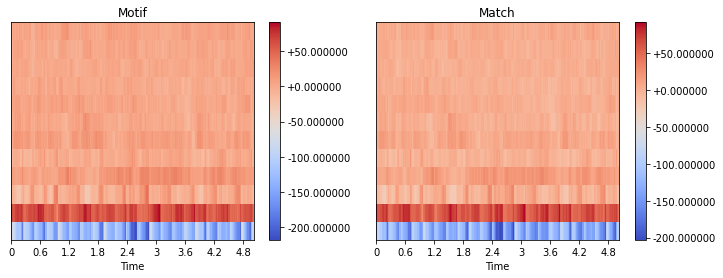

############ MOTIF 674 ############
start: 6911, time: 0:02:38.905986


nearest match: 3649, time: 0:01:23.902177


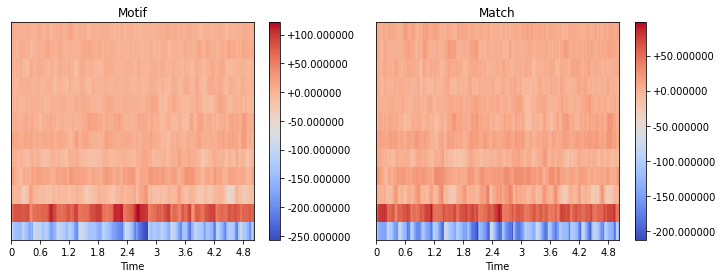

############ MOTIF 676 ############
start: 3976, time: 0:01:31.420952


nearest match: 7238, time: 0:02:46.424762


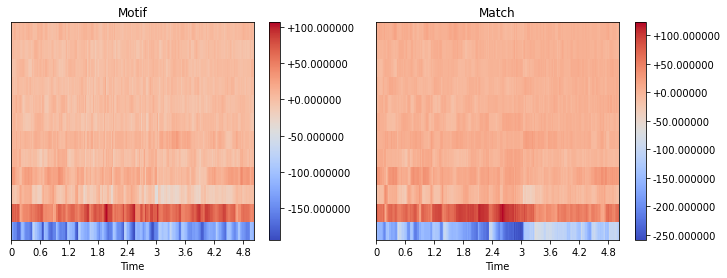

In [13]:
# get the motif repetitions and display the audio segments
for index, row in top_3_motifs.iterrows():
    print("############ MOTIF {} ############".format(index))
    m = row['m']
    start = row['Indices'][0]
    end = start + m
    segment = y[start*hop_length:end*hop_length]
    #print in seconds and datetime format
    print("start: {}, time: {}".format(start, datetime.timedelta(seconds=librosa.core.frames_to_time(start, sr=sr, hop_length=hop_length))))
    
    display(ipd.Audio(segment, rate=sr))
    #display nearest match
    nearest_match = row['Indices'][1]
    end_match = nearest_match + m
    segment_match = y[nearest_match*hop_length:end_match*hop_length]
    print("nearest match: {}, time: {}".format(nearest_match, datetime.timedelta(seconds=librosa.core.frames_to_time(nearest_match, sr=sr, hop_length=hop_length))))
    display(ipd.Audio(segment_match, rate=sr))

    #plot znormalized motif and match 
    motif = X[:,start:end]
    match = X[:,nearest_match:end_match]
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    librosa.display.specshow(motif, sr=sr, x_axis='time')
    plt.colorbar(format="%+2f")
    plt.title("Motif")
    plt.subplot(1,2,2)
    librosa.display.specshow(match, sr=sr, x_axis='time')
    plt.colorbar(format="%+2f")
    plt.title("Match")
    plt.show()

    
    